In [114]:
import sys
import spotipy
import yaml
import spotipy.util as util
from pprint import pprint
import json
import argparse
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
sns.set()

In [115]:
def load_config():
    stream = open('config.yaml')
    user_config = yaml.load(stream, Loader=yaml.FullLoader)
    return user_config

user_config = load_config()

In [116]:
token = util.prompt_for_user_token(user_config['username'], scope='playlist-read-private', client_id=user_config['client_id'], client_secret=user_config['client_secret'], redirect_uri=user_config['redirect_uri'])
sp = spotipy.Spotify(auth=token)

In [117]:
def get_playlist_info(username, playlist_uri):
    offset = 0
    playlist_id = playlist_uri.split(':')[2]
    tracks = []
    uris = []
    names = []
    playlist_name = sp.user_playlist(username, playlist_id)['name']
    while True:
        results = sp.user_playlist_tracks(username, playlist_id, offset=offset)
        tracks += results['items']
        if results['next'] is not None:
            offset += 100
        else:
            break

    for track in tracks:
        names.append(track['track']['name'])
        uris.append(track['track']['uri'])
    
    return playlist_name, names, uris

In [118]:
def get_features_for_playlist(df, username, uri):
    playlist_name, names, uris = get_playlist_info(username, uri)
    for track_name, track_uri in zip(names, uris):
        # print(json.dumps(track, indent=4))              
        # DEBUG STATEMENT
        
        # save metadata stuff
        row = []
        name = track_name
        features = sp.audio_features(track_uri)
        for col in df.columns:
            if col == "name":
                row.append(name)
            elif col == "track_URI":
                row.append(track_uri)
            elif col == "playlist":
                row.append(playlist_name)
            else:
                row.append(features[0][col])
        df.loc[len(df.index)] = row
    return df

In [119]:
df = pd.DataFrame(columns=['name', 'track_URI', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'playlist'])


In [120]:
df = get_features_for_playlist(df, user_config['username'], 'spotify:playlist:3VZCYCHOtahASqlkxE8vJx')
df


,name,track_URI,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,playlist
0,Way With Words,spotify:track:6ioeN8jQ8Qc3tS8dhpoAVi,0.3590,0.785,0.530,0.001980,0.0774,-6.995,0.0634,146.380,0.7290,twenty
1,Caroline,spotify:track:3S5mohVxC0Xuj0tgZ7vU7g,0.7260,0.506,0.456,0.000037,0.1100,-10.635,0.0479,149.600,0.4060,twenty
2,Hear Me Calling,spotify:track:13ZyrkCDmRz5xY3seuAWYk,0.3080,0.699,0.687,0.000036,0.1210,-3.997,0.1060,88.932,0.4990,twenty
3,94 Bentley,spotify:track:0xxbDtdmc88FOV7YvpEtft,0.0792,0.696,0.558,0.000000,0.1620,-5.253,0.0512,113.000,0.2170,twenty
4,I Feel Like I'm Drowning,spotify:track:5h0ODSutX73Vt4vZsmmph0,0.7050,0.719,0.575,0.003340,0.0899,-5.436,0.0460,104.894,0.2350,twenty
...,...,...,...,...,...,...,...,...,...,...,...,...
308,Skin,spotify:track:1AbrmVzD5wWan2Vid0BwC7,0.9770,0.501,0.141,0.070000,0.0874,-17.147,0.0376,120.118,0.0831,twenty
309,Skin,spotify:track:0vucUDJGFNrxCazRoMTmkR,0.9780,0.351,0.128,0.055800,0.0880,-17.115,0.0392,119.936,0.0760,twenty
310,Night - Live at Roadburn 2018,spotify:track:1EhsAcLIW0e67BZbgplHLn,0.0177,0.495,0.631,0.000017,0.7030,-8.472,0.0409,100.968,0.1480,twenty
311,Veka,spotify:track:3tZUvdXFsmQ1PjHqKt2FhK,0.0136,0.302,0.614,0.249000,0.0906,-11.680,0.0876,109.910,0.1100,twenty


In [121]:
track_info = df[['name', 'track_URI', 'playlist']]
df_X = df.drop(columns=['name', 'track_URI', 'playlist'])
df_X.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,0.3590,0.785,0.530,0.001980,0.0774,-6.995,0.0634,146.380,0.729
1,0.7260,0.506,0.456,0.000037,0.1100,-10.635,0.0479,149.600,0.406
2,0.3080,0.699,0.687,0.000036,0.1210,-3.997,0.1060,88.932,0.499
3,0.0792,0.696,0.558,0.000000,0.1620,-5.253,0.0512,113.000,0.217
4,0.7050,0.719,0.575,0.003340,0.0899,-5.436,0.0460,104.894,0.235


In [122]:
scaler = StandardScaler()
X_std = scaler.fit_transform(df_X)

In [123]:
pca = PCA()
pca.fit(X_std)

PCA(copy=True, iterated_power=&#39;auto&#39;, n_components=None, random_state=None,
    svd_solver=&#39;auto&#39;, tol=0.0, whiten=False)

In [124]:
# The attribute shows how much variance is explained by each of the nine features
evr = pca.explained_variance_ratio_
evr

array([0.29193951, 0.16089537, 0.12490188, 0.11111739, 0.09848244,
       0.08737206, 0.06552903, 0.03959299, 0.02016933])

Text(0, 0.5, &#39;Cumulative Explained Variance&#39;)

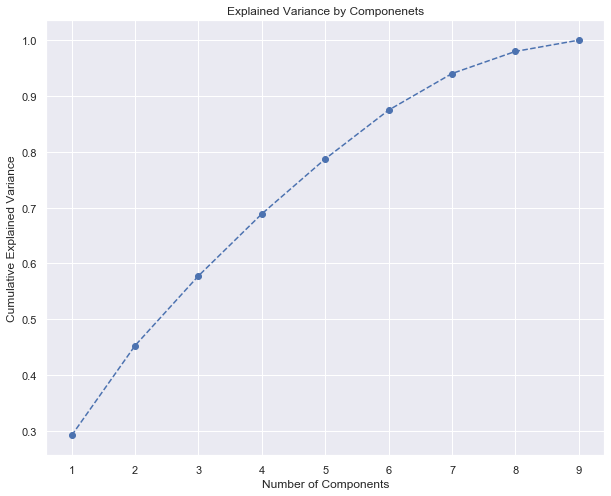

In [125]:
plt.figure(figsize=(10,8))
plt.plot(range(1, len(df_X.columns)+1), evr.cumsum(), marker='o', linestyle='--')
plt.title('Explained Variance by Componenets')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

A good rule of thumb is to preserve around 80% of the variance. In this case, we will keep 5 components.

In [126]:
pca = PCA(n_components=5)
pca.fit(X_std)
scores_pca = pca.transform(X_std)
scores_pca

array([[-1.01383095, -1.26648089,  0.79617945,  0.26806822, -0.88105584],
       [ 1.13281493,  0.17062007,  0.0408901 ,  0.81036223, -0.13965744],
       [-1.44843718, -1.19220635, -0.40630523, -0.64982933,  0.15764734],
       ...,
       [-0.79049314,  2.60688761,  0.50625855, -1.86954314,  4.03763662],
       [ 0.68785978,  1.57310459, -1.01940305,  0.47719481, -0.03043933],
       [-0.2633562 , -0.21837779,  0.43730286, -0.72867475,  0.51350908]])

In [137]:
wcss = []
for i in range(1, 21):
    kmeans_pca = KMeans(i, init='k-means++', random_state=42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

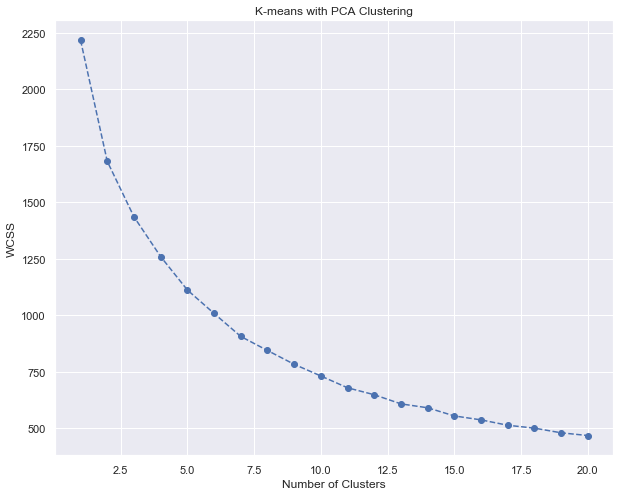

In [138]:
plt.figure(figsize=(10,8))
plt.plot(range(1, 21), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means with PCA Clustering')
plt.show()

In [156]:
n_clusters = 6
kmeans_pca = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
kmeans_pca.fit(scores_pca)

KMeans(algorithm=&#39;auto&#39;, copy_x=True, init=&#39;k-means++&#39;, max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances=&#39;auto&#39;,
       random_state=42, tol=0.0001, verbose=0)

In [157]:
df_seg_pca_kmeans = pd.concat([df_X.reset_index(drop=True), pd.DataFrame(scores_pca)], axis=1)
df_seg_pca_kmeans.columns.values[-5:] = ['Component 1', 'Component 2', 'Component 3', 'Component 4', 'Component 5']
df_seg_pca_kmeans['Cluster'] = kmeans_pca.labels_
df_seg_pca_kmeans.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,Component 1,Component 2,Component 3,Component 4,Component 5,Cluster
0,0.3590,0.785,0.530,0.001980,0.0774,-6.995,0.0634,146.380,0.729,-1.013831,-1.266481,0.796179,0.268068,-0.881056,2
1,0.7260,0.506,0.456,0.000037,0.1100,-10.635,0.0479,149.600,0.406,1.132815,0.170620,0.040890,0.810362,-0.139657,4
2,0.3080,0.699,0.687,0.000036,0.1210,-3.997,0.1060,88.932,0.499,-1.448437,-1.192206,-0.406305,-0.649829,0.157647,2
3,0.0792,0.696,0.558,0.000000,0.1620,-5.253,0.0512,113.000,0.217,-0.822709,-0.148070,-0.883805,-0.371777,0.113773,1
4,0.7050,0.719,0.575,0.003340,0.0899,-5.436,0.0460,104.894,0.235,0.199951,-0.964451,-0.822605,-0.362224,-0.241874,4


In [158]:
df_seg_pca_kmeans['Cluster_Label'] = df_seg_pca_kmeans['Cluster'].map({
    0: 'first',
    1: 'second',
    2: 'third',
    3: 'fourth',
    4: 'fifth',
    5: 'sixth',
}) 

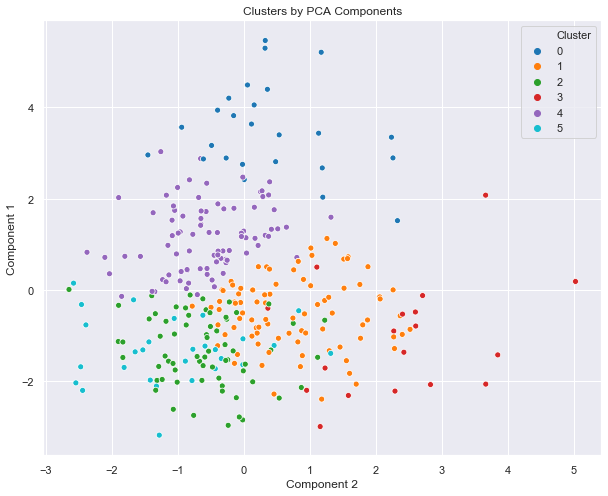

In [159]:
x = df_seg_pca_kmeans['Component 2']
y = df_seg_pca_kmeans['Component 1']
plt.figure(figsize=(10, 8))
sns.scatterplot(x, y, hue=df_seg_pca_kmeans['Cluster'], palette = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:cyan'])
plt.title('Clusters by PCA Components')
plt.show()

In [160]:
df['Cluster'] = df_seg_pca_kmeans['Cluster']
df.head()

,name,track_URI,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,playlist,Cluster
0,Way With Words,spotify:track:6ioeN8jQ8Qc3tS8dhpoAVi,0.3590,0.785,0.530,0.001980,0.0774,-6.995,0.0634,146.380,0.729,twenty,2
1,Caroline,spotify:track:3S5mohVxC0Xuj0tgZ7vU7g,0.7260,0.506,0.456,0.000037,0.1100,-10.635,0.0479,149.600,0.406,twenty,4
2,Hear Me Calling,spotify:track:13ZyrkCDmRz5xY3seuAWYk,0.3080,0.699,0.687,0.000036,0.1210,-3.997,0.1060,88.932,0.499,twenty,2
3,94 Bentley,spotify:track:0xxbDtdmc88FOV7YvpEtft,0.0792,0.696,0.558,0.000000,0.1620,-5.253,0.0512,113.000,0.217,twenty,1
4,I Feel Like I'm Drowning,spotify:track:5h0ODSutX73Vt4vZsmmph0,0.7050,0.719,0.575,0.003340,0.0899,-5.436,0.0460,104.894,0.235,twenty,4


In [166]:
for i in range(1, n_clusters+1):
    result = sp.user_playlist_create(user_config['username'], 'cluster'+str(i), public=True, collaborative=False, description='')
    playlist_id = result['id']
    sp.playlist_add_items(playlist_id, list(df.loc[df['Cluster'] == i - 1]['track_URI']))


&lt;matplotlib.collections.LineCollection at 0x12784dd68&gt;

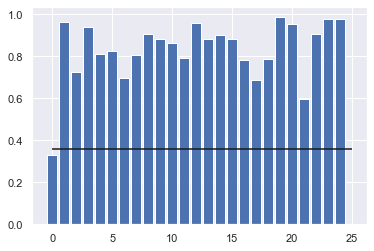

In [174]:
cluster_zero = df.loc[df['Cluster'] == 0]
y = cluster_zero['acousticness']
x = [i for i in range(len(y))]
plt.bar(x, y)
plt.hlines(np.mean(df['acousticness']), 0, len(y))

&lt;matplotlib.collections.LineCollection at 0x127b40518&gt;

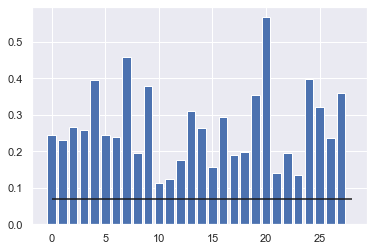

In [180]:
cluster_six = df.loc[df['Cluster'] == 5]
y = cluster_six['speechiness']
x = [i for i in range(len(y))]
plt.bar(x, y)
plt.hlines(np.mean(df['speechiness']), 0, len(y))